In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import seaborn as sbs

/Users/petercable/virtenvs/ooi/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
filename = 'deployment0003_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20161110T000000.935191-20161110T102128.580840.nc'

In [3]:
ds = xr.open_dataset(filename)

In [4]:
# I don't want to see all the attributes
ds.attrs = {}
# And let's focus on just one parameter for now, convert to dataframe since the is all scalar data
df = ds[['seawater_temperature', 'seawater_temperature_qc_executed', 'seawater_temperature_qc_results']].to_dataframe()
# Re-index by time
df = df.set_index('time')
# drop lat/lon
df = df.drop(['lat', 'lon'], axis=1)

In [5]:
df.head()

,seawater_temperature,seawater_temperature_qc_executed,seawater_temperature_qc_results
time,,,
2016-11-10 00:00:00.935191,8.391116,29,21
2016-11-10 00:00:01.935922,8.391242,29,21
2016-11-10 00:00:02.935403,8.391430,29,21
2016-11-10 00:00:03.935715,8.392496,29,21
2016-11-10 00:00:04.935821,8.393562,29,21


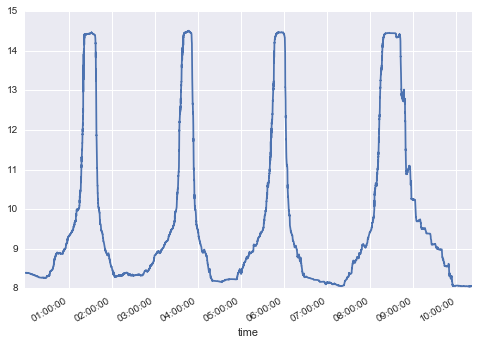

In [6]:
df.seawater_temperature.plot()

QC table
```
Test name              Bit position
                         15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0
global_range_test         0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
dataqc_localrangetest     0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
dataqc_spiketest          0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
dataqc_polytrendtest      0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
dataqc_stuckvaluetest     0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
dataqc_gradienttest       0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
dataqc_propagateflags     0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
```

The QC flags for all tests are OR'd together to produce a single value for each data point. So, given a qc_executed value of 29 we can see which tests were run by reversing the process:

In [7]:
np.unpackbits(np.array(29).astype('uint8'))

array([0, 0, 0, 1, 1, 1, 0, 1], dtype=uint8)

If you compare this result to the table above you can see that the following tests were executed:

```
global_range_test
dataqc_spiketest
dataqc_polytrendtest
dataqc_stuckvaluetest
```

We can craft a function to create new booleans variables for each test run containing the pass/fail results from that test:

In [8]:
def parse_qc(dataframe):
    names = {
        0: 'global_range_test',
        1: 'dataqc_localrangetest',
        2: 'dataqc_spiketest',
        3: 'dataqc_polytrendtest',
        4: 'dataqc_stuckvaluetest',
        5: 'dataqc_gradienttest',
        7: 'dataqc_propagateflags',
    }
    # Just in case a different set of tests were run on some datapoint
    # *this should never happen*
    executed = np.bitwise_or.reduce(dataframe.seawater_temperature_qc_executed.values)
    executed_bits = np.unpackbits(executed.astype('uint8'))
    for index, value in enumerate(executed_bits[::-1]):
        if value:
            name = names.get(index)
            mask = 2**index
            values = (dataframe.seawater_temperature_qc_results.values & mask) > 0
            df[name] = values
    dataframe.drop(['seawater_temperature_qc_executed', 'seawater_temperature_qc_results'], axis=1, inplace=True)

In [9]:
parse_qc(df)

In [10]:
df.head()

,seawater_temperature,global_range_test,dataqc_spiketest,dataqc_polytrendtest,dataqc_stuckvaluetest
time,,,,,
2016-11-10 00:00:00.935191,8.391116,True,True,False,True
2016-11-10 00:00:01.935922,8.391242,True,True,False,True
2016-11-10 00:00:02.935403,8.391430,True,True,False,True
2016-11-10 00:00:03.935715,8.392496,True,True,False,True
2016-11-10 00:00:04.935821,8.393562,True,True,False,True


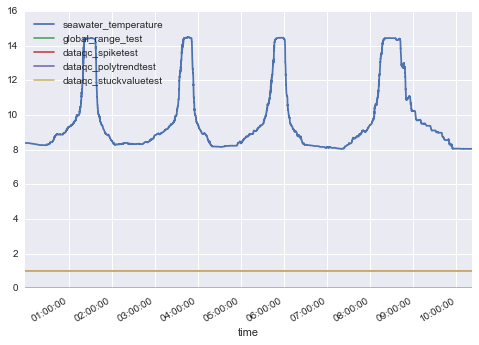

In [11]:
df.plot()